In [11]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

In [6]:
#pip install opencv-python

In [17]:
data_dir=Path("samples/")
images=list(data_dir.glob("*.png"))

In [22]:
kernel=np.ones((3,1),np.uint8)
borderType=cv2.BORDER_CONSTANT

In [25]:
def pad(src):
    top=int(0.05*src.shape[0])
    bottom=top
    left=int(0.15*src.shape[1])
    right=left
    des=cv2.copyMakeBorder(src,top,bottom,left+1,right,borderType,None,255)
    return cv2.bitwise_not(des)

In [27]:
x=[]
y=[]
for image in images:
    im=cv2.imread(str(image),0)
    threshold=cv2.adaptiveThreshold(im,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,199,5)
    erosion=cv2.dilate(threshold,kernel,iterations=2)
    s=str(image)
    for i in range(5):
        x.append(pad(erosion[:,(30+23*i):(30+23*(i+1))]))
        y.append(s[-9+i])

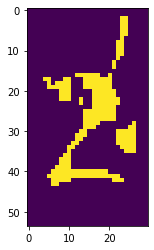

In [38]:
plt.imshow(x[25]);

In [39]:
y[25]

'2'

In [59]:
data=np.reshape(x,(-1,54,30,1))

In [40]:
x=np.array(x)
y=np.array(y)

In [44]:
np.unique(y)

array(['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g',
       'm', 'n', 'p', 'w', 'x', 'y'], dtype='<U1')

In [46]:
train = []
l=['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g','m', 'n', 'p', 'w', 'x', 'y']
for j in y:
    i=l.index(j)
    a=[]
    for r in range(19):
        if(r==i):
            a.append(1)
        else:
            a.append(0)
    a=np.array(a)
    train.append(a)
train=np.array(train)  

In [48]:
train

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [77]:
from keras.models import Sequential
from keras.layers import BatchNormalization,MaxPool2D,Dense,Conv2D,Flatten,Dropout
from keras.callbacks import EarlyStopping,LearningRateScheduler
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")

In [78]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (50,30,1)))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(19, activation = "softmax"))
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [79]:
X_train, X_val, Y_train, Y_val = train_test_split(data, train, test_size = 0.1, random_state= 2)
X_train=X_train/255.0
X_val=X_val/255.0

In [80]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = False, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

In [82]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=50),
                              epochs =  30, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // 50
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
93/93 [==============================] - 21s 215ms/step - loss: 2.7809 - accuracy: 0.1333 - val_loss: 1.3976 - val_accuracy: 0.5500
Epoch 2/30
93/93 [==============================] - 21s 226ms/step - loss: 1.7328 - accuracy: 0.4542 - val_loss: 0.6837 - val_accuracy: 0.7962
Epoch 3/30
93/93 [==============================] - 22s 231ms/step - loss: 1.1319 - accuracy: 0.6411 - val_loss: 0.4581 - val_accuracy: 0.8423
Epoch 4/30
93/93 [==============================] - 23s 243ms/step - loss: 0.7855 - accuracy: 0.7538 - val_loss: 0.3859 - val_accuracy: 0.8788
Epoch 5/30
93/93 [==============================] - 22s 233ms/step - loss: 0.6274 - accuracy: 0.8063 - val_loss: 0.3499 - val_accuracy: 0.8769
Epoch 6/30
93/93 [==============================] - 23s 244ms/step - loss: 0.5251 - accuracy: 0.8306 - val_loss: 0.2685 - val_accuracy: 0.9077
Epoch 7/30
93/93 [==============================] - 21s 227ms/step - loss: 0.4254 - accuracy: 0.8558 - val_loss: 0.2341 - val_accuracy: 0.9212

In [83]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 50, 30, 16)        416       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 50, 30, 16)        6416      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 25, 15, 16)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 25, 15, 16)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 25, 15, 32)        12832     
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 25, 15, 32)        25632     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 12, 7, 32)        

In [85]:
_, accuracy=model.evaluate(X_val, Y_val)
print('Accuracy: %.2f' % (accuracy*100))

17/17 [==============================] - 0s 15ms/step - loss: 0.0811 - accuracy: 0.9712
Accuracy: 97.12
